## Imports

In [2]:
import numpy as np
from skimage import io
import random
import cv2 

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard

import os,sys
from importlib import reload


from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split

## Base de données

### Pretraitement

In [3]:
IMG_SIZE = 28


def add_noise_salt(image):
    row,col,ch = image.shape
    s_vs_p = 0.01
    amount = 1.0
    out = np.copy(image)
    # Salt mode
    num_salt = np.ceil(image.size * s_vs_p)
    coords = [np.random.randint(0, i, int(num_salt))
          for i in image.shape]
    out[coords] = 255
    return out

def add_noise(path_src, img_size = 256):
    try:
            img = cv2.imread(path_src)
#             gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
#             print("gray")
            img_y = cv2.resize(img,(img_size, img_size))
            plt.imshow(img)
            plt.show()
            plt.imshow(img_y)
            plt.show()
            degraded = add_noise_salt(img_y)
            plt.imshow(cv2.cvtColor(degraded, cv2.COLOR_BGR2GRAY))
            plt.show()
            
            return cv2.cvtColor(degraded, cv2.COLOR_BGR2GRAY)
    except Exception as e: 
            print(e)
            return None
        
def add_noise_to_images(path_src, path_dst, img_size = 256):
    for img_name in os.listdir(path_src):
        img = add_noise(path_src + '/' + img_name, img_size)
        cv2.imwrite(path_dst + '/1' + img_name, img)
        
        
# add_noise_to_images("degraded","degraded_pt2", IMG_SIZE )

In [16]:

training_data = []
def create_training_data(path_X, path_y):
    X  = []
    y = []
    for img in os.listdir(path_X):
        # img_array = cv2.imread(os.path.join(path_X,img))
        img_array = cv2.imread(os.path.join(path_X,img), cv2.IMREAD_GRAYSCALE)
        new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
        X.append(new_array)
    for img in os.listdir(path_y):
        img_array = cv2.imread(os.path.join(path_y,img))
        img_array = cv2.cvtColor(img_array, cv2.COLOR_BGR2GRAY)
        new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
        y.append(new_array)
    return X, y

        
X, y = create_training_data("/home/e20210007011/Documents/M2/projet_image/dataset_X/", "/home/e20210007011/Documents/M2/projet_image/dataset_Y/")
print("X size :", len(X))
# noisy_train, noisy_test, clean_train, clean_test = train_test_split(X, y, test_size=0.33) #random_state=42


X size : 9014


In [26]:

noisy_train = X[: int(len(X)*0.8)]
noisy_test = X[int(len(X)*0.8):]
clean_train = y[:int(len(y)*0.8)]
clean_test = y[int(len(y)*0.8):]

print("noisy_train size: ", len(noisy_train), " noisy_test size: ",len(noisy_test))

noisy_train size:  7211  noisy_test size:  1803


In [27]:
# -1 specifies that this dimension should be dynamically computed based on the number of input values in x
# 1 because it's grayscale
noisy_train = np.array(noisy_train).reshape(-1, IMG_SIZE, IMG_SIZE, 1)
noisy_test =  np.array(noisy_test).reshape(-1, IMG_SIZE, IMG_SIZE, 1)
clean_train = np.array(clean_train).reshape(-1, IMG_SIZE, IMG_SIZE, 1)
clean_test = np.array(clean_test).reshape(-1, IMG_SIZE, IMG_SIZE, 1)
print("noisy_train shape: ",noisy_train.shape, "  length :", len(noisy_train))
print("clean_train : ",clean_train.shape)
print("noisy_test  : ",noisy_test.shape)
print("clean_test  : ",clean_test.shape)

print('Avant la normalisation : Min={}, max={}'.format(noisy_train.min(),noisy_train.max()))

xmax = noisy_train.max() 
noisy_train = noisy_train/ xmax
noisy_test = noisy_test/ xmax

ymax = clean_train.max() 
clean_train = clean_train/ ymax
clean_test = clean_test/ ymax

print('Après la normalisation: Min={}, max={}'.format(noisy_train.min(),noisy_train.max()))




noisy_train shape:  (7211, 28, 28, 1)   length : 7211
clean_train :  (7211, 28, 28, 1)
noisy_test  :  (1803, 28, 28, 1)
clean_test  :  (1803, 28, 28, 1)
Avant la normalisation : Min=0, max=255
Après la normalisation: Min=0.0, max=1.0


## Modele

#### Encoder

In [38]:
latent_dim = 2
inputs    = keras.Input(shape=(28, 28, 1))
x         = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(inputs)
x         = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x         = layers.Flatten()(x)
x         = layers.Dense(16, activation="softmax")(x)
z         = layers.Dense(latent_dim)(x)

encoder = keras.Model(inputs, z, name="encoder")
encoder.summary()

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 14, 14, 32)        320       
                                                                 
 conv2d_3 (Conv2D)           (None, 7, 7, 64)          18496     
                                                                 
 flatten_1 (Flatten)         (None, 3136)              0         
                                                                 
 dense_3 (Dense)             (None, 16)                50192     
                                                                 
 dense_4 (Dense)             (None, 2)                 34        
                                                                 
Total params: 69,042
Trainable params: 69,042
Non-trainable

#### Decoder

In [39]:

inputs  = keras.Input(shape=(latent_dim,))
x       = layers.Dense(7 * 7 * 64, activation="relu")(inputs)
x       = layers.Reshape((7, 7, 64))(x)
x       = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x       = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
outputs = layers.Conv2DTranspose(1, 3, activation="softmax", padding="same")(x)

decoder = keras.Model(inputs, outputs, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense_5 (Dense)             (None, 3136)              9408      
                                                                 
 reshape_1 (Reshape)         (None, 7, 7, 64)          0         
                                                                 
 conv2d_transpose_3 (Conv2DT  (None, 14, 14, 64)       36928     
 ranspose)                                                       
                                                                 
 conv2d_transpose_4 (Conv2DT  (None, 28, 28, 32)       18464     
 ranspose)                                                       
                                                                 
 conv2d_transpose_5 (Conv2DT  (None, 28, 28, 1)        289 

#### AE


In [40]:
inputs    = keras.Input(shape=(28, 28, 1))

latents   = encoder(inputs)
outputs   = decoder(latents)

ae = keras.Model(inputs,outputs, name="ae")

ae.compile(optimizer=keras.optimizers.Adam(), loss='binary_crossentropy')
# ae.compile(optimizer=keras.optimizers.Adam(), loss='mean_squared_error')

## Entrainement

In [41]:
batch_size = 512
epochs = 8
fit_verbosity = 2

history = ae.fit(noisy_train, clean_train,
                 batch_size      = batch_size,
                 epochs          = epochs,
                 verbose         = fit_verbosity,
                 validation_data = (noisy_test, clean_test)  )


Epoch 1/8
15/15 - 6s - loss: 0.6916 - val_loss: 0.6899 - 6s/epoch - 372ms/step
Epoch 2/8
15/15 - 4s - loss: 0.6889 - val_loss: 0.6899 - 4s/epoch - 281ms/step
Epoch 3/8
15/15 - 4s - loss: 0.6881 - val_loss: 0.6876 - 4s/epoch - 288ms/step
Epoch 4/8
15/15 - 4s - loss: 0.6793 - val_loss: 0.6774 - 4s/epoch - 283ms/step
Epoch 5/8
15/15 - 4s - loss: 0.6718 - val_loss: 0.6745 - 4s/epoch - 292ms/step
Epoch 6/8
15/15 - 4s - loss: 0.6681 - val_loss: 0.6681 - 4s/epoch - 292ms/step
Epoch 7/8
15/15 - 4s - loss: 0.6645 - val_loss: 0.6654 - 4s/epoch - 286ms/step
Epoch 8/8
15/15 - 4s - loss: 0.6628 - val_loss: 0.6639 - 4s/epoch - 274ms/step


## Resultats (Prediction)

226/226 [==============================] - 1s 2ms/step


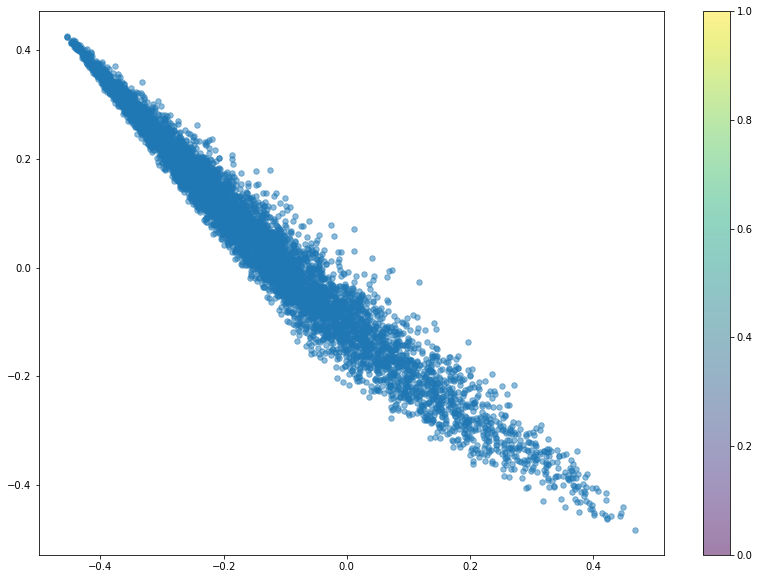

In [42]:
model = ae
encoder=model.get_layer('encoder')


# ---- Get latent points

z = encoder.predict(noisy_train)

# ---- Show them

fig = plt.figure(figsize=(14, 10))
plt.scatter(z[:, 0] , z[:, 1], cmap= 'tab10', alpha=0.5, s=30)
plt.colorbar()
# fidle.scrawler.save_fig('08-Latent-space')
plt.show()

In [ ]:
print(model.get_layer('encoder'))
print(model.get_layer('decoder'))

1/1 [==============================] - 0s 110ms/step


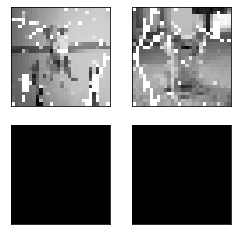

In [43]:
to_predict = noisy_train[:2]
predicted = ae.predict(to_predict.reshape(-1, IMG_SIZE, IMG_SIZE, 1))
nrows=2
ncols=2
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, sharey=True, figsize=(4,4))
for images, row in zip([to_predict, predicted], axes):
    for img, ax in zip(images, row):
        img = img*255
#         print(img)
        ax.imshow(img.reshape((IMG_SIZE, IMG_SIZE)), cmap='Greys_r')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

# Generate degraged photos
